<div style="text-align:center"><span style="color:red; font-size:28pt">GMM, kmeans</span></div>

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statistics
import os, sys

sns.set()
plt.rcParams['figure.figsize'] = [8, 6]

# Getting PATH for RNA3 and RNA9

In [3]:
# replace with the actual paths
pathRNA3 = '/Volumes/anyaext/desktop_linux_june2020/Analysis/RNA3_short/alb_bc_qs_4/workspace/pass/0/'
pathRNA9 = '/Volumes/anyaext/desktop_linux_june2020/Analysis/RNA9_short/alb_bc_qs_4/workspace/pass/0/'
dirsRNA3 = os.listdir(pathRNA3)
dirsRNA9 = os.listdir(pathRNA9)

In [4]:
def parse_fastq(fastq):
    seq = fastq.split('\n')[1]
    quality = []
    for s in fastq.split("\n")[3]:
        quality.append(1-(10**-((ord(s)-33)/10.0)))
    return seq,quality

# Importing the data & extracting necessary values

In [5]:
I_len_RNA3, I_len_RNA9 = [], []
data_mean_RNA3, data_mean_RNA9 = [], []
data_std_RNA3, data_std_RNA9 = [], []
RNA3_len, RNA9_len = [], []
prob_mean_RNA3, prob_mean_RNA9 = [], []
prob_std_RNA3, prob_std_RNA9 = [], []

for d in dirsRNA3[0:500]:
    if 'fast5' in d:
        try:
            read = h5py.File(pathRNA3+d,'r')
            sampling_rate = read['UniqueGlobalKey/channel_id'].attrs['sampling_rate']
            
            for key in read['Raw/Reads'].keys():
                
                raw = read.get('Raw/Reads/'+key+'/Signal')
                
                I_len_RNA3.append(len(raw)/sampling_rate)
                data_mean_RNA3.append(np.mean(raw))
                data_std_RNA3.append(np.std(raw))
                
            fastq = read['Analyses/Basecall_1D_000/BaseCalled_template/Fastq'][()].decode('utf-8')
            seq, quality = parse_fastq(fastq)
            RNA3_len.append(len(seq))
            prob_mean_RNA3.append(np.mean(quality))
            prob_std_RNA3.append(np.std(quality))
                
        except OSError:
            pass
        
for d in dirsRNA9[0:500]:
    if 'fast5' in d:
        try:
            read = h5py.File(pathRNA9+d,'r')
            sampling_rate = read['UniqueGlobalKey/channel_id'].attrs['sampling_rate']
            for key in read['Raw/Reads'].keys():
                
                raw = read.get('Raw/Reads/'+key+'/Signal')
                
                I_len_RNA9.append(len(raw)/sampling_rate)
                data_mean_RNA9.append(np.mean(raw))
                data_std_RNA9.append(np.std(raw))
            
            fastq = read['Analyses/Basecall_1D_000/BaseCalled_template/Fastq'][()].decode('utf-8')
            seq, quality = parse_fastq(fastq)
            RNA9_len.append(len(seq))
            prob_mean_RNA9.append(np.mean(quality))
            prob_std_RNA9.append(np.std(quality))
                
        except OSError:
            pass

# Constructing one dataframe

In [6]:
df9 = pd.DataFrame({'sample_name':['RNA9']*len(data_std_RNA9),
                    'Raw Reads Std':data_std_RNA9,
                    'Avg Probability':prob_mean_RNA9,
                    'Current Length':I_len_RNA9,
                    'Basecalled Seq Length':RNA9_len})

df3 = pd.DataFrame({'sample_name':['RNA3']*len(data_std_RNA3),
                    'Raw Reads Std':data_std_RNA3,
                    'Avg Probability':prob_mean_RNA3,
                    'Current Length':I_len_RNA3,
                    'Basecalled Seq Length':RNA3_len})


In [9]:
df = df9.append(df3)
print(len(df))
df.head()

1000


,sample_name,Raw Reads Std,Avg Probability,Current Length,Basecalled Seq Length
0,RNA9,134.110545,0.721670,11.875830,186
1,RNA9,112.548222,0.701576,6.464807,195
2,RNA9,129.681995,0.730218,5.143426,222
3,RNA9,127.827730,0.799764,7.893426,440
4,RNA9,120.839284,0.650798,9.696879,87


# Scatterplots and Distributions 

## 1. Plot directly from dataframe with hue

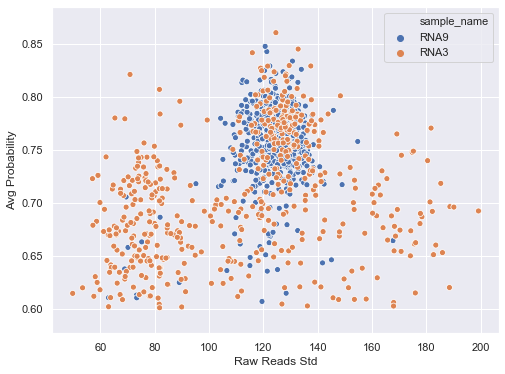

In [10]:
ax = sns.scatterplot(x='Raw Reads Std', y='Avg Probability', hue="sample_name",
                     data=df)

## 2. Define a jointplot procedure: scatterplot + KDE in the main graph, marginal distributions for each on the side

In [12]:
def jointplot_2(dfg, dfm, xaxis = 'Basecalled Seq Length', yaxis = 'Current Length'):
    
    # xaxis, yaxis define which columns to take for the plot
    # dfg stands for "dataframe with G-quadruplex", dfm "dataframe with Mutated seq"
    # just to plot consistently G-quad data with red colors, mutated with blue
    
    # PLOT PARAMETERS
    alpha_scatter = 0.6
    alpha_kde = 0.8
    n_levels = 10
    colormaps = ['spring', 'winter']
    shade = False
    marker_size = 50
    marker_type = '+'
    fontsize='x-large'
    # %%%%%%%%%%%%%%%%
    
    # first, using generic seaborn jointplot 
    axs = sns.jointplot(x=xaxis, y=yaxis, data=dfg, kind="scatter", color='red', 
                        marker=marker_type, height=7, alpha=alpha_scatter, s=marker_size)

    # 2D KDEplot on top of scatterplot
    axs.plot_joint(sns.kdeplot, zorder=3, n_levels=n_levels, cmap=colormaps[0], 
                   alpha=alpha_kde, shade=shade)

    # by default, sns.jointplot will use histograms for jointplot with scattered points
    # but we want a 1D-KDE instead so we clear the marginal axis (axs object under .ax_marg_x)
    axs.ax_marg_x.cla()
    axs.ax_marg_y.cla()
    # and plot 1D-KDE instead
    sns.distplot(dfg[xaxis], ax=axs.ax_marg_x, hist=False, color='r', kde_kws={"shade": True})
    sns.distplot(dfg[yaxis], ax=axs.ax_marg_y, vertical=True, hist=False, color='r', kde_kws={"shade": True})
    
    # jointplot doesn't allow to plot two sets of data so we use a trick here:
    # we substitute the intrinsic data (x, y) that is stored in the axis object with new data
    # (dfm), and plot everything once again; this will not erase whatever is alrd there
    axs.x = dfm[xaxis]
    axs.y = dfm[yaxis]

    # scatter first
    axs.ax_joint.scatter(xaxis, yaxis, data=dfm, color='royalblue', marker=marker_type, 
                         alpha=alpha_scatter, s=marker_size)
    
    # then 2D KDE again, zorder stands for layer order on the graph (can b important for visibility)
    axs.plot_joint(sns.kdeplot, zorder=2, n_levels=n_levels, cmap=colormaps[1], 
                   alpha=alpha_kde, shade=shade)

    # and adding 1D marginal distributions
    sns.distplot(dfm[xaxis], ax=axs.ax_marg_x, hist=False, color='b', kde_kws={"shade": True})
    sns.distplot(dfm[yaxis], ax=axs.ax_marg_y, vertical=True, hist=False, color='b', kde_kws={"shade": True})

    # setting the names of the axes, main and marginal
    axs.set_axis_labels(xaxis, yaxis, fontsize=fontsize)
    axs.ax_marg_x.set_xlabel("")
    axs.ax_marg_y.set_ylabel("")

    return
    

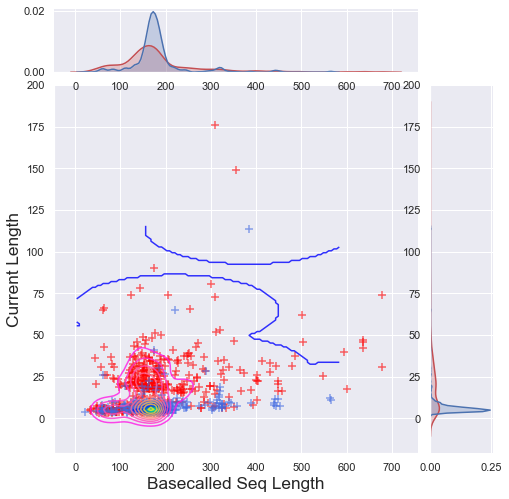

In [13]:
jointplot_2(df3, df9, 'Basecalled Seq Length', 'Current Length')

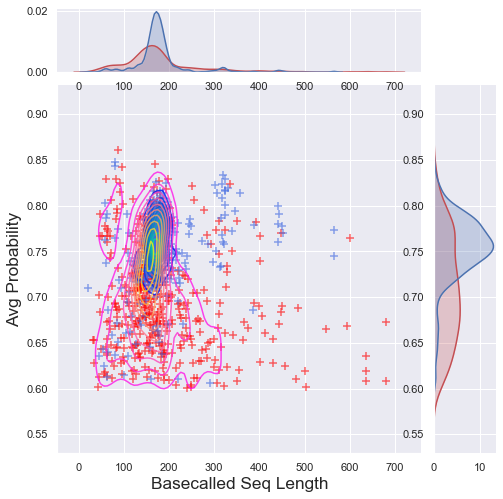

In [14]:
jointplot_2(df3, df9, 'Basecalled Seq Length', 'Avg Probability')

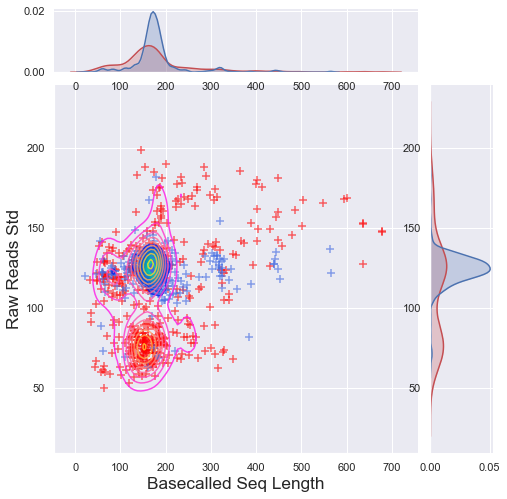

In [15]:
jointplot_2(df3, df9, 'Basecalled Seq Length', 'Raw Reads Std')

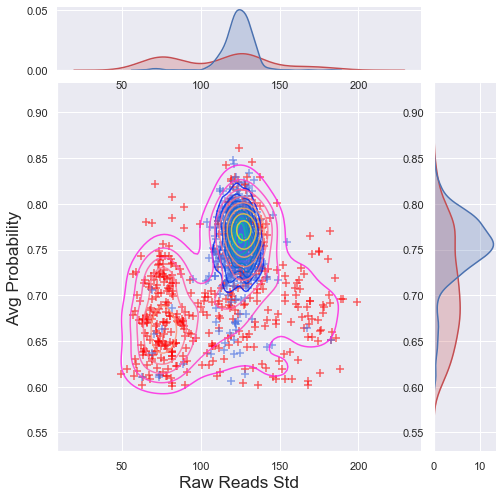

In [16]:
jointplot_2(df3, df9, 'Raw Reads Std', 'Avg Probability')

# Clustering: Gaussian Mixture Models

(1000, 2)


Text(0.5, 0, 'n_components')

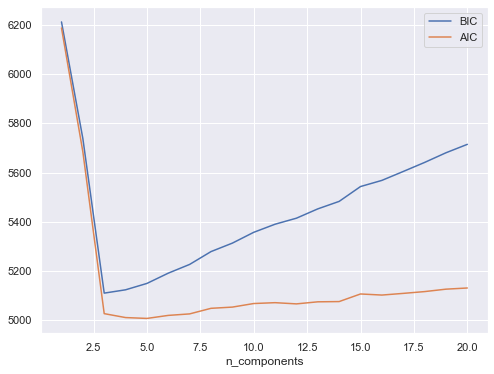

In [17]:
from sklearn.mixture import GaussianMixture

# in which parameter space we want to cluster?
xaxis, yaxis = 'Raw Reads Std', 'Avg Probability'
#xaxis, yaxis = 'Basecalled Seq Length', 'Raw Reads Std'

# slicing two columns and stacking them together, then transposing 
X = np.vstack((df[xaxis], df[yaxis])).T
print(np.shape(X))

# let's see how well diff number of clusters will fit our data using these information criteria
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X) for n in n_components]
plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

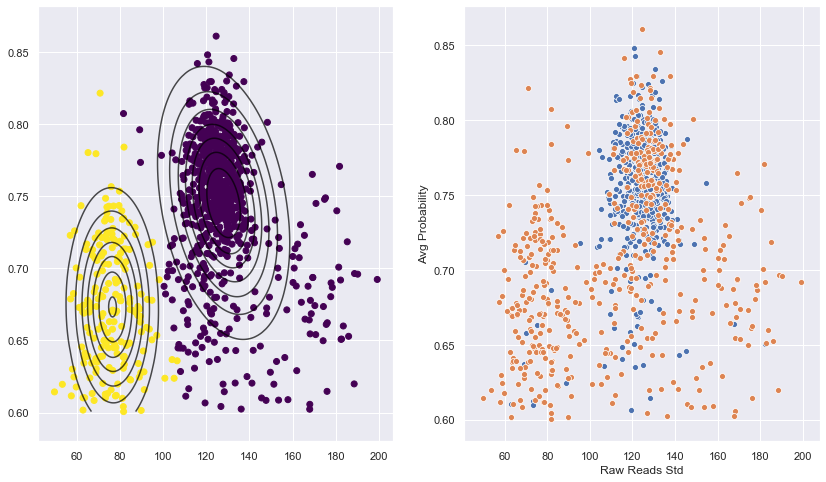

In [18]:
# we know that there's two clusters. let's stick with two
gmm = GaussianMixture(n_components=2)
# here the model is learning from the data (X)
# please note that we're not supplying the labels (RNA3, RNA9) here, 
# so it's just guessing -> UNSUPERVISED learning
gmm.fit(X)

# using trained model on the same dataset and asking it to predict the labels, just to visualize
labels = gmm.predict(X)

# the model (gmm) now contains everything it has learned from the data X, and it also estimated 
# the means and covariances of the distributions that it assigned to these clusters
# this will be generally useful
means = gmm.means_ 
covariances = gmm.covariances_


from scipy.stats import multivariate_normal

sns.set()
plt.rcParams['figure.figsize'] = [14, 8]

# making a uniform 2D grid for plotting
x,y = np.meshgrid(np.sort(X[:,0]),np.sort(X[:,1]))
XY = np.array([x.flatten(),y.flatten()]).T

# plotting our datapoints with labels used as color indicators
plt.subplot(121)
plt.scatter(X[:,0], X[:,1], c=labels, cmap='viridis')
# plus contours showing the predicted means and variances+covariances for the gaussian dists
for m,c in zip(means,covariances):
    multi_normal = multivariate_normal(mean=m,cov=c)
    plt.contour(np.sort(X[:,0]),np.sort(X[:,1]),multi_normal.pdf(XY).reshape(len(X),len(X)),colors='black',alpha=0.7)

# separately plotting the real data
plt.subplot(122)
sns.scatterplot(x=xaxis, y=yaxis, data=df9)
sns.scatterplot(x=xaxis, y=yaxis, data=df3)


In [19]:
print(labels[0:100])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


# Clustering: kmeans

In [ ]:
from sklearn.cluster import KMeans
# try to cluster in the following parameter spaces:
# 1
xaxis, yaxis = 'Basecalled Seq Length', 'Raw Reads Std'
# 2
xaxis, yaxis = 'Raw Reads Std', 'Avg Probability'


# 1D Gaussian Mixture: calculate ratio of the RNA3 populations from the estimated means, variances

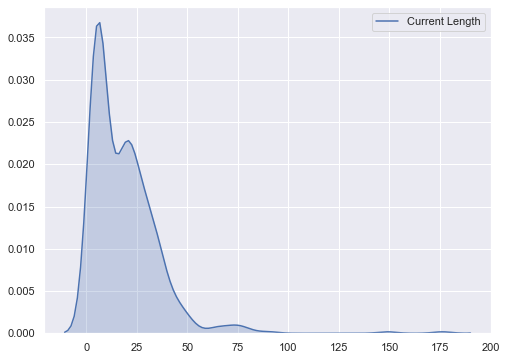

In [22]:
plt.rcParams['figure.figsize'] = [8, 6]

# real dist
sns.kdeplot(df3['Current Length'], shade=True)

In [49]:
import scipy.stats as stats

# just a 1D array to fit-predict
X = np.array(df3['Current Length'])
X = X.reshape(-1, 1)
print(np.shape(X))

# define the model, fit
gmm_1d = GaussianMixture(n_components=2, covariance_type='full')
gmm_1d.fit(X)

# extract estimates
means = gmm_1d.means_ 
covariances = gmm_1d.covariances_

print(means)
print(np.sqrt(covariances))

(500, 1)
[[15.7458512 ]
 [48.13799994]]
[[[11.10677639]]

 [[32.92910046]]]


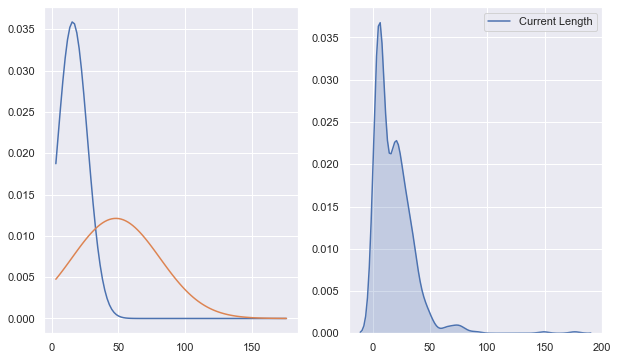

In [50]:
# a linspace to sample out simulated dist on
x = np.linspace(min(df3['Current Length']), max(df3['Current Length']), 100)

# widen figsize so it fits two plots better
plt.rcParams['figure.figsize'] = [10, 6]

# simulated
plt.subplot(121)
for m, c in zip(means, covariances):
    plt.plot(x, stats.norm.pdf(x, m, np.sqrt(c[0])))

# real
plt.subplot(122)
sns.kdeplot(df3['Current Length'], shade=True)